In [8]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun
import reg_icp as ricp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Loading data sets
cell_profiler = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv')
print(f'There are {len(cell_profiler)} rows in the Batch A')

There are 5167 rows in the Batch A


### Feature selection

So far I have filtered all the columns that contained something related to the MITO chanell. Now, according to the paper "A phenomic approach for antiviral drug discovery", there are features, specifically correlation, 
neighbours, concavalin and syto, that are more important. Hence, I am going to filter more to use only that information. 

In [3]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target','cell_profiler_vector']]

### Now training

1. Creating training and tests sets

In [5]:
# We get the input values
X_filtered =  filtered_cell_profiler.iloc[:,:-2]
y = 1000*cell_profiler.iloc[:,-2]

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-0.257914,-0.503403,0.368115,-1.095521,0.177077,-0.430929,0.795305,-0.046790,-1.321457,-0.836086,...,0.170116,0.076296,0.748799,0.169360,-0.087611,0.648681,-0.203668,-0.033160,0.743814,0.100900
1,-1.351104,-0.978272,-1.053952,-0.941708,-0.821612,-1.089779,-2.370635,1.530151,-0.441446,0.073379,...,-0.776891,0.733642,0.276178,0.731734,-0.770309,-1.259507,-0.719190,-0.907220,-1.347615,-1.314692
2,-0.292257,0.206746,0.076387,-0.559541,-0.361829,-0.121880,0.222068,2.100450,-2.210764,-2.021869,...,-0.614305,-0.786486,-0.920356,-1.143140,-0.760895,0.285831,-1.617476,-0.108020,0.564839,-1.243213
3,-1.259874,-1.693025,-2.044711,-3.152486,-3.409335,-2.732680,-2.720392,4.814035,-2.349717,-1.265924,...,-0.800588,3.368160,-2.423337,-1.235297,0.734348,-1.713448,-1.929259,1.127889,-2.226118,-4.486775
4,-1.125852,-1.304193,-0.699630,-0.727178,-0.826347,-0.663788,-0.484115,1.217376,-1.327913,-0.397548,...,-1.279884,-0.715382,0.055487,0.213475,-1.757143,-1.007877,-1.262469,-1.670823,-0.765251,-0.973857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,0.350542,0.622401,0.055192,0.439353,0.994491,0.853169,0.157524,-0.164303,0.301825,0.633466,...,0.196056,0.113013,0.016828,-0.100313,0.076090,-0.028682,-0.091369,0.237186,0.033689,0.317694
5163,0.669399,0.758400,1.809696,0.700002,-0.092329,0.631864,0.470503,-0.634794,0.510016,0.671948,...,0.126944,0.582826,0.207708,0.359684,0.784367,0.052846,0.619493,0.865013,0.070952,0.614092
5164,1.569386,1.777094,1.089193,0.563271,0.849976,0.478177,0.878359,-0.736187,0.917663,0.617015,...,1.293937,0.712350,-0.155374,0.377773,1.247087,-0.225002,1.372138,0.984667,-0.556620,0.879421
5165,-0.205780,-0.207491,0.691815,0.442894,0.047307,0.353626,-0.649646,-0.652776,1.547321,1.198609,...,0.470867,0.184642,0.455690,0.281784,0.432123,0.098151,0.763248,0.342401,0.017309,0.964534


2) K-fold cross validationd and linear regression

In [6]:
y_frame = pd.DataFrame({'MITO': y.values.flatten()})
y_frame = fun.labelling_v2(y_frame, col_reference=0, labels_position = 1, label_positive=1, label_negative=0, threshold=7.5)
y_frame = y_frame.groupby('Labels_0').count()
print(f'Percentage of positives in the total dataframe with {7.5} as threshold: {y_frame.MITO[1]*100 / y_frame.MITO.sum()}%')

Percentage of positives in the total dataframe with 7.5 as threshold: 2.5933810721888912%


In [11]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)
# Split data into proper training set and clibration set
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.3)

best_rf = RandomForestRegressor(min_samples_leaf = 3, n_estimators = 200, n_jobs=-1,random_state=0)

intervals_rf, testPred_rf = ricp.ICPRegression(X_train, y_train, X_calib, y_calib, X_test, best_rf, returnPredictions = False)

In [12]:
intervals_rf

array([[ 9.05361504, 11.14732372],
       [ 7.39603158,  9.48974026],
       [ 8.43612798, 10.52983667],
       ...,
       [ 7.67059373,  9.76430241],
       [ 8.69346266, 10.78717134],
       [10.08714272, 12.1808514 ]])

In [63]:
icp_result_rf = pd.DataFrame(intervals_rf,columns=['Lower_bound', 'Upper_bound'])
icp_result_rf['y_predicted'] = testPred_rf
icp_result_rf['y_test'] = y_test.values.tolist()

In [64]:
icp_result_rf

,Lower_bound,Upper_bound,y_predicted,y_test
0,9.053615,11.147324,10.100469,11.029739
1,7.396032,9.489740,8.442886,7.841662
2,8.436128,10.529837,9.482982,8.377502
3,9.796744,11.890452,10.843598,10.439209
4,9.252644,11.346353,10.299498,10.438612
...,...,...,...,...
1029,9.795732,11.889440,10.842586,10.621040
1030,9.858124,11.951832,10.904978,10.091538
1031,7.670594,9.764302,8.717448,9.666374
1032,8.693463,10.787171,9.740317,9.105669


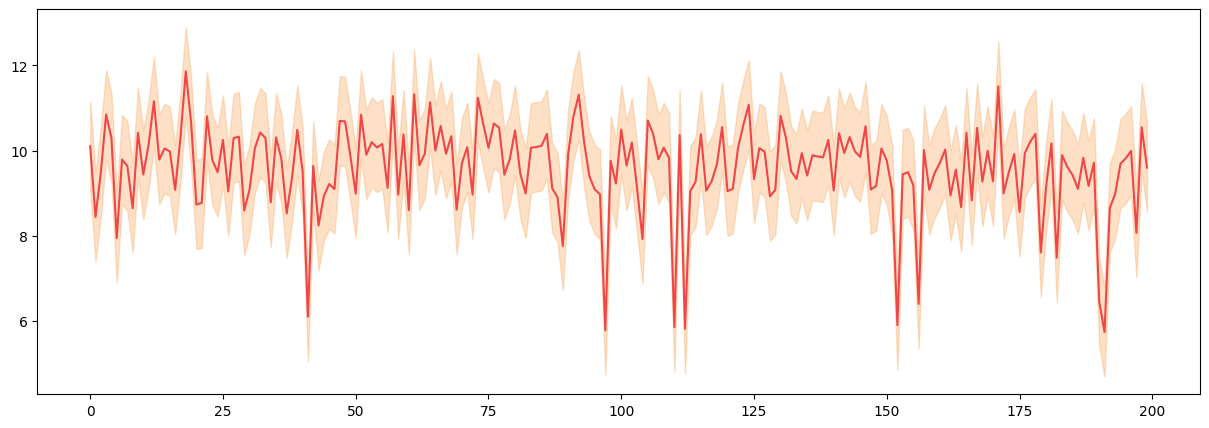

In [80]:
npoints = 200
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(icp_result_rf.index[:npoints],icp_result_rf['y_predicted'][:npoints], color=[.937, .275, .282])
#ax.plot(icp_result_rf.index[0:150],icp_result_rf['Lower_bound'][0:150])
#ax.plot(icp_result_rf.index[0:150],icp_result_rf['Upper_bound'][0:150])
ax.fill_between(icp_result_rf.index[:npoints],icp_result_rf['Lower_bound'][:npoints], 
                icp_result_rf['Upper_bound'][:npoints], color=[.98, .702, .447],alpha=0.4)
plt.show()